#  Sequence to Sequence with Attention
In this project we will be teaching a neural network to translate from
French to English.

This is made possible by the simple but powerful idea of the [sequence
to sequence network](https://arxiv.org/abs/1409.3215>), in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

To improve upon this model we'll use an [attention
mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder
learn to focus over a specific range of the input sequence.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
%matplotlib inline

## Preparing Data
The data for this project is a set of many thousands of English to
French translation pairs.

In [2]:
def download_dataset():
    ! wget https://download.pytorch.org/tutorial/data.zip
    ! unzip data.zip

In [3]:
# wget https://www.manythings.org/anki/spa-eng.zip
# mv _about.txt spa.txt data

In [4]:
# to download the dataset
#download_dataset()

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.

In [5]:
SOS_token = 1
EOS_token = 2
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"PAD": 0, "SOS": 1, "EOS": 2, "UNK": 3}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3: "UNK"}
        self.n_words = 4  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [6]:
def unicodeToAscii(s):
    """Turn a Unicode string to plain ASCII
    
    https://stackoverflow.com/a/518232/2809427
    """
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    """Lowercase, trim, and remove non-letter characters"""
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [7]:
def readLangs(filename):
    # Read the file and split into lines
    lines = open(filename).read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    return pairs

In [8]:
MAX_LENGTH = 15

# Selecting some sentences
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# Filtering by sentence length
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs

In [9]:
def prepareData(data_filename):
    pairs = readLangs(data_filename)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    
    #randomize the data with a fixed seed for repeatability
    random.seed(4)
    random.shuffle(pairs)
    #choose the first 10 pairs for testing and the rest for training
    valid_pairs = pairs[0:300]
    train_pairs = pairs[300:len(pairs)]
    
    print("number of valid pairs: %s" % len(valid_pairs))
    print("number of train pairs: %s" % len(train_pairs))
    
    input_lang = Lang("english")
    output_lang = Lang("french")
    
    print("Counting words...")
    cnt = 0
    for pair in pairs:
        input_lang.addSentence(pair[1])
        output_lang.addSentence(pair[0])
        
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs, train_pairs, valid_pairs

In [10]:
input_lang, output_lang, pairs, train_pairs, valid_pairs = prepareData("data/eng-fra.txt")
random.seed(4)
print(random.choice(pairs))

Read 135842 sentence pairs
Trimmed to 12823 sentence pairs
number of valid pairs: 300
number of train pairs: 12523
Counting words...
Counted words:
english 5036
french 3310
['we re still vulnerable .', 'nous sommes encore vulnerables .']


In [11]:
train_pairs[0]

['i m no liar .', 'je ne suis pas un menteur .']

## Dataset

In [12]:
def encode_sentence(s, vocab2index, N=MAX_LENGTH+2, padding_start=True):
    enc = np.zeros(N, dtype=np.int32)
    enc1 = np.array([SOS_token] + [vocab2index.get(w, vocab2index["UNK"]) for w in s.split()] + [EOS_token])
    l = min(N, len(enc1))
    if padding_start:
        enc[:l] = enc1[:l]
    else:
        enc[N-l:] = enc1[:l]
    return enc, l

In [13]:
train_pairs[0]

['i m no liar .', 'je ne suis pas un menteur .']

In [14]:
encode_sentence(train_pairs[0][0], input_lang.word2index, padding_start=False)

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   3, 170,
          3,   3,  11,   2], dtype=int32), 7)

In [15]:
encode_sentence(train_pairs[0][1], output_lang.word2index)

(array([ 1,  3,  3,  3,  3,  3,  3, 10,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       dtype=int32), 9)

In [16]:
class PairDataset(Dataset):
    def __init__(self, pairs, input_lang, output_lang):
        self.pairs = pairs
        self.input_word2index = input_lang.word2index
        self.output_word2index = output_lang.word2index
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        x, n_x = encode_sentence(self.pairs[idx][1], self.input_word2index, padding_start=False)
        y, n_y = encode_sentence(self.pairs[idx][0], self.output_word2index)
        return x, y
    
train_ds = PairDataset(train_pairs, input_lang, output_lang)
valid_ds = PairDataset(valid_pairs, input_lang, output_lang)

In [17]:
train_ds[0]

(array([  0,   0,   0,   0,   0,   0,   0,   0,   1,   4,  58,   5,  60,
          7, 424,  11,   2], dtype=int32),
 array([  1,   4,   5, 193, 258,  10,   2,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0], dtype=int32))

In [18]:
batch_size=5
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

## The Seq2Seq Model

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A Sequence to Sequence network <https://arxiv.org/abs/1409.3215>, or
seq2seq network, or Encoder Decoder network <https://arxiv.org/pdf/1406.1078v3.pdf>, is a model consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

### The Encoder
The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

![](imgs/encoder-network.png)

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=0)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        output, hidden = self.gru(x)
        return output, hidden

In [20]:
x, y = next(iter(train_dl))

In [21]:
x, y

(tensor([[   0,    0,    0,    0,    0,    0,    1,   51,   52,    7,  281,   34,
           257,   68, 1043,   11,    2],
         [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,
             4,    5, 1978,   11,    2],
         [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,   40,
            41,  251,  503,   11,    2],
         [   0,    0,    0,    0,    0,    0,    0,    1,    4,    5,   89,  185,
           232,   52, 3822,   11,    2],
         [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,  137,
            52,   26, 1080,   11,    2]], dtype=torch.int32),
 tensor([[   1,   56,   52,   65, 2111, 2112,   10,    2,    0,    0,    0,    0,
             0,    0,    0,    0,    0],
         [   1,    4,    5, 1509,   10,    2,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0],
         [   1,   11,   12,  101, 1789,   10,    2,    0,    0,    0,    0,    0,
             0,    0,    0,    0,   

In [22]:
input_size = input_lang.n_words
hidden_size = 2
encoder = EncoderRNN(input_size, hidden_size)

In [23]:
enc_outputs, enc_hidden = encoder(x.long())

In [24]:
enc_outputs.shape, enc_hidden.shape

(torch.Size([5, 17, 2]), torch.Size([1, 5, 2]))

The Attention Decoder
-----------

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

In [25]:
class AttnDotDecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size, max_length=MAX_LENGTH):
        super(AttnDotDecoderRNN, self).__init__()

        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=0)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(0.3)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_step, last_hidden, enc_outputs):
        embedded = self.embedding(input_step)
        embedded = self.dropout(embedded)

        output, hidden = self.gru(embedded, last_hidden)
        
        # Calculate attention weights from the current GRU hidden
        attention_scores = torch.einsum('ijk,ik->ij', [enc_outputs, hidden[-1]])
        attn_weights = F.softmax(attention_scores, dim=1)    
        
        # apply attention to enc_outputs
        attn_applied = torch.einsum('ijk,ij->ik', [enc_outputs, attn_weights])
        
        concat_input = torch.cat((output.squeeze(1), attn_applied), 1) 
        concat_output = F.relu(self.attn_combine(concat_input))
        output = self.out(concat_output)

        return output, hidden, attn_weights

In [26]:
output_size = output_lang.n_words
hidden_size = 2

In [27]:
embedding = nn.Embedding(output_size, hidden_size)
attn = nn.Linear(hidden_size * 2, 1)
attn_combine = nn.Linear(hidden_size * 2, hidden_size)
dropout = nn.Dropout(0.1)
gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
out = nn.Linear(hidden_size, output_size)

In [28]:
y[:,0].shape

torch.Size([5])

In [29]:
batch_size = y.size(0)
decoder_input = SOS_token*torch.ones(batch_size,1)
decoder_input.shape

torch.Size([5, 1])

In [30]:
hidden = enc_hidden
xx = decoder_input
xx = embedding(xx.long())
output, hidden = gru(xx, hidden)

In [31]:
output.shape

torch.Size([5, 1, 2])

In [32]:
enc_length = 17
attention_scores = torch.zeros(batch_size, enc_length)
for ei in range(enc_length):
    attention_scores[:, ei] = (enc_outputs[:, ei, :]*hidden[-1]).sum(1)

In [33]:
c = torch.einsum('ijk,ik->ij', [enc_outputs, hidden[-1]])
c.shape

torch.Size([5, 17])

In [34]:
attention_scores==c

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       dtype=torch.uint8)

In [35]:
attn_weights = F.softmax(attention_scores, dim=1)
attn_weights.shape

torch.Size([5, 17])

In [36]:
attn_weights.shape

torch.Size([5, 17])

In [37]:
enc_outputs.shape

torch.Size([5, 17, 2])

In [38]:
attention_scores = torch.einsum('ijk,ik->ij', [enc_outputs, hidden[-1]])
attn_weights = F.softmax(attention_scores, dim=1)    
        
attn_applied = torch.einsum('ijk,ij->ik', [enc_outputs, attn_weights])

In [39]:
attn_applied2 = torch.zeros(batch_size, enc_length, hidden_size)
for ei in range(hidden_size):
    attn_applied2[:,:, ei] = enc_outputs[:,:,ei]*attn_weights

In [40]:
attn_applied2.sum(1) 

tensor([[0.7636, 0.4783],
        [0.6857, 0.4225],
        [0.6047, 0.4266],
        [0.5685, 0.4783],
        [0.7432, 0.5769]], grad_fn=<SumBackward2>)

In [41]:
attn_applied

tensor([[0.7636, 0.4783],
        [0.6857, 0.4225],
        [0.6047, 0.4266],
        [0.5685, 0.4783],
        [0.7432, 0.5769]], grad_fn=<AsStridedBackward>)

In [42]:
output.squeeze(1).shape

torch.Size([5, 2])

In [43]:
concat_input = torch.cat((output.squeeze(1), attn_applied), 1) 
concat_input.shape

torch.Size([5, 4])

In [44]:
concat_output = F.relu(attn_combine(concat_input))
output = out(concat_output)

In [45]:
# testing the whole thing
batch_size = y.size(0)
decoder_input = SOS_token*torch.ones(batch_size,1).long()
decoder = AttnDotDecoderRNN(output_size, hidden_size)

In [46]:
output, hidden, attn_weights = decoder(decoder_input, hidden, enc_outputs)

Training
========

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

**Teacher forcing** is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.

In [47]:
def train_batch(x, y, encoder, decoder, encoder_optimizer, decoder_optimizer,
                teacher_forcing_ratio=0.5):

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    batch_size = y.size(0)
    target_length = y.size(1)

    enc_outputs, enc_hidden = encoder(x)

    loss = 0
    dec_input = y[:,0].unsqueeze(1) # allways SOS
    hidden = enc_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(1, target_length):
        output, hidden, attention = decoder(dec_input, hidden, enc_outputs)
        yi =  y[:, di]
        if (yi>0).sum() > 0:
            loss += F.cross_entropy(
                output, yi, ignore_index = 0, reduction="sum")/(yi>0).sum()
        if use_teacher_forcing:
            dec_input = y[:, di].unsqueeze(1)  # Teacher forcing: Feed the target
                                               # as the next input
        else:                
            dec_input = output.argmax(dim=1).unsqueeze(1).detach() # Feeds predictions

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()

In [48]:
def train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 10,
          teacher_forcing_ratio=0.5):
    for i in range(epochs):
        total_loss = 0
        total = 0
        encoder.train()
        decoder.train()
        for x, y in train_dl:
            x = x.long().cuda()
            y = y.long().cuda()
            loss = train_batch(x, y, encoder, decoder, enc_optimizer, dec_optimizer,
                               teacher_forcing_ratio)
            total_loss = loss*x.size(0)
            total += x.size(0)
        if i % 10 == 0:
            print("train loss %.3f" % (total_loss / total))   

In [49]:
input_size = input_lang.n_words
output_size = output_lang.n_words
hidden_size = 300
encoder = EncoderRNN(input_size, hidden_size).cuda()
decoder = AttnDotDecoderRNN(output_size, hidden_size).cuda()
enc_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
dec_optimizer = optim.Adam(decoder.parameters(), lr=0.001) 

In [50]:
batch_size= 1000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [51]:
train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 100)

train loss 2.828
train loss 1.678
train loss 1.322
train loss 1.094
train loss 0.595
train loss 0.384
train loss 0.309
train loss 0.230
train loss 0.393
train loss 0.145


In [52]:
enc_optimizer = optim.Adam(encoder.parameters(), lr=0.0001)
dec_optimizer = optim.Adam(decoder.parameters(), lr=0.0001) 
train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 100)

train loss 0.267
train loss 0.113
train loss 0.101
train loss 0.104
train loss 0.089
train loss 0.187
train loss 0.086
train loss 0.082
train loss 0.079
train loss 0.081


In [53]:
train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 300, teacher_forcing_ratio=0.0)

train loss 0.155
train loss 0.108
train loss 0.137
train loss 0.156
train loss 0.169
train loss 0.118
train loss 0.112
train loss 0.119
train loss 0.123
train loss 0.097
train loss 0.084
train loss 0.117
train loss 0.108
train loss 0.102
train loss 0.123
train loss 0.098
train loss 0.095
train loss 0.081
train loss 0.097
train loss 0.073
train loss 0.081
train loss 0.086
train loss 0.087
train loss 0.066
train loss 0.074
train loss 0.088
train loss 0.055
train loss 0.069
train loss 0.148
train loss 0.052


In [54]:
train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 300, teacher_forcing_ratio=0.0)

train loss 0.063
train loss 0.083
train loss 0.058
train loss 0.063
train loss 0.048
train loss 0.065
train loss 0.049
train loss 0.052
train loss 0.047
train loss 0.045
train loss 0.049
train loss 0.055
train loss 0.045
train loss 0.042
train loss 0.048
train loss 0.052
train loss 0.068
train loss 0.034
train loss 0.038
train loss 0.036
train loss 0.033
train loss 0.034
train loss 0.052
train loss 0.038
train loss 0.039
train loss 0.037
train loss 0.043
train loss 0.031
train loss 0.033
train loss 0.039


## Visualizing Attention

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

In [55]:
def showAttention(x, y_hat, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + x +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + y_hat + ['<EOS>'])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [56]:
batch_size=5
train_dl_2 = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

x, y = next(iter(train_dl_2)) 
x = x.long().cuda()
y = y.long().cuda()

In [57]:
decoder = decoder.eval()
encoder = encoder.eval()
batch_size = x.size(0)
enc_outputs, enc_hidden = encoder(x)
dec_input = SOS_token*torch.ones(batch_size, 1).long().cuda()  # SOS
hidden = enc_hidden

output, hidden, attention = decoder(dec_input, hidden, enc_outputs)

In [73]:
x

tensor([[  0,   0,   0,   0,   0,   0,   0,   1,   4,   5,  89,   8,  12, 317,
         297, 128,   2],
        [  0,   0,   0,   0,   0,   1,   4,  58,  99,  60, 100, 101, 102,  29,
          75,  11,   2],
        [  0,   1,   4,  58,  99, 119, 120, 121,  15, 122, 123, 124, 125, 126,
         127, 128,   2],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  51,  52,   7, 197,
         198,  11,   2],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  12,  13, 166,
         437,  11,   2],
        [  0,   0,   0,   0,   0,   0,   0,   1,   4,   5, 177,  29, 155,  70,
         178,  11,   2],
        [  0,   0,   0,   0,   0,   1,  12,  92,  13,  60, 172, 173, 126,  64,
          71,  11,   2],
        [  0,   0,   0,   0,   0,   0,   0,   0,   1,   4,  58,   5,  60, 103,
         104,  11,   2],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  96,  97,  98,
         540,  11,   2],
        [  0,   0,   0,   0,   0,   0,   1, 164,  19,  90, 117, 

In [72]:
attention

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1612e-40, 8.4074e-40,
         5.5043e-33, 1.9845e-19, 4.2462e-19, 9.4815e-10, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.4230e-43,
         1.1695e-28, 2.5129e-20, 1.3815e-17, 1.5414e-09, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0746e-41, 2.1855e-32,
         4.1302e-29, 9.6910e-17, 1.4413e-16, 5.3673e-09, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2668e-37, 1.8503e-33,
         2.5714e-32, 1.7120e-27, 5.4031e-21, 1.0128e-09, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0

## Evaluation

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.

In [60]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [61]:
def decoding(x, y, encoder, decoder, max_length=MAX_LENGTH+2):
    decoder = decoder.eval()
    encoder = encoder.eval()
    loss = 0 
    with torch.no_grad():
        batch_size = x.size(0)
        enc_outputs, enc_hidden = encoder(x)
        dec_input = SOS_token*torch.ones(batch_size, 1).long().cuda()  # SOS
        hidden = enc_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(batch_size, max_length, max_length)

        for di in range(1, max_length):
            output, hidden, attention = decoder(dec_input, hidden, enc_outputs)
            decoder_attentions[:, di, :] = attention.detach()
            pred = output.argmax(dim=1)
            yi =  y[:, di]
            if (yi>0).sum() > 0:
                loss += F.cross_entropy(
                    output, yi, ignore_index = 0, reduction="sum")/(yi>0).sum()
            decoded_words.append(pred.cpu().numpy())
            dec_input = output.argmax(dim=1).unsqueeze(1).detach()

        return loss/batch_size, np.transpose(decoded_words), decoder_attentions

In [74]:
def print_results(x, y, encoder, decoder, attention=False, max_length=MAX_LENGTH+2):
    loss, decoded_words, attentions = decoding(x, y, encoder, decoder)
    for i in range(x.shape[0]):
        xi = x[i].cpu().numpy()
        yi = y[i].cpu().numpy()
        y_hat = decoded_words[i]
        x_sent = [input_lang.index2word[t] for t in xi if t > 3]
        y_sent = [output_lang.index2word[t] for t in yi if t > 3]
        y_hat_sent = [output_lang.index2word[t] for t in y_hat if t > 3]
        print('>', ' '.join(x_sent))
        print('=', ' '.join(y_sent))
        print('<', ' '.join(y_hat_sent))
        print('')
        attns = attentions[i,:len(y_hat_sent)+1:,max_length-len(x_sent)-1:]
        if attention:
            showAttention(x_sent, y_hat_sent, attns)

In [79]:
batch_size=300
valid_dl_2 = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

x, y = next(iter(valid_dl_2)) 
x = x.long().cuda()
y = y.long().cuda()

loss, decoded_words, attentions = decoding(x, y, encoder, decoder)
loss

tensor(0.1935, device='cuda:0')

In [82]:
batch_size=10
train_dl_2 = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

x, y = next(iter(train_dl_2)) 
x = x.long().cuda()
y = y.long().cuda()

In [83]:
print_results(x, y, encoder, decoder)

> vous etes creatives .
= you re creative .
< you re creative .

> je m excuse pour mon mauvais francais . je suis encore debutant .
= i m sorry for my terrible french . i m still a beginner .
< i m sorry for my terrible french . i m still a beginner .

> vous etes tres efficaces .
= you re very efficient .
< you re very efficient .

> je vais y songer .
= i m going to sleep on it .
< i m going to sleep on it .

> tu ne penses pas clairement .
= you re not thinking clearly .
< you re not thinking clearly .

> il est assez mignon non ?
= he s kind of cute isn t he ?
< he s kind of cute isn t he ?

> je vais arreter d essayer d etre amicale avec toi .
= i m going to stop trying to be friendly with you .
< i m going to stop trying to be friendly with you .

> vous etes inoubliables .
= you re unforgettable .
< you re unforgettable .

> je suis familier de cette partie de la ville .
= i am familiar with this part of town .
< i am familiar with this part of town .

> nous sommes inutiles .


In [84]:
batch_size=10
valid_dl_2 = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

x, y = next(iter(valid_dl_2)) 
x = x.long().cuda()
y = y.long().cuda()

In [85]:
print_results(x, y, encoder, decoder)

> je ne suis pas votre ennemie .
= i m not your enemy .
< i am not your enemy .

> tu es en train de prevoir quelque chose pas vrai ?
= you re planning something aren t you ?
< you re enjoying something aren t you ?

> je ne vais pas bien du tout .
= i am not well at all .
< i m not at all all .

> je suis desole je ne vous ai pas reconnu .
= i m sorry i didn t recognize you .
< i m sorry i didn t recognize you .

> vous etes chanceuse .
= you re fortunate .
< you re fortunate .

> je suis desole mon pere est sorti .
= i m sorry my father is out .
< i m sorry my father is out .

> je ne suis pas actuellement arme .
= i m now unarmed .
< i m not in . .

> je suis vegetarienne .
= i m vegetarian .
< i am a vegetarian .

> j en ai fini avec mon travail .
= i am through with my work .
< i m through with my work with job .

> c est toi la chef .
= you re the leader .
< you re the leader .



> je ne suis pas votre ennemie .
= i m not your enemy .
< i am not your enemy .



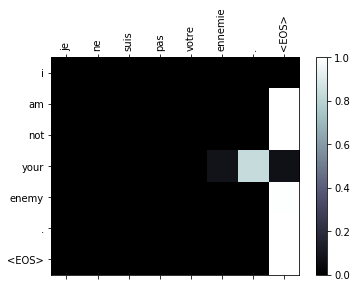

> tu es en train de prevoir quelque chose pas vrai ?
= you re planning something aren t you ?
< you re enjoying something aren t you ?



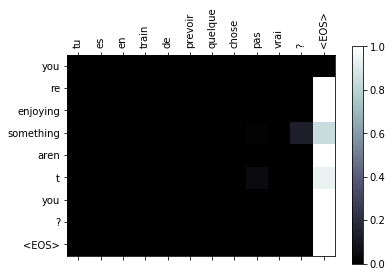

> je ne vais pas bien du tout .
= i am not well at all .
< i m not at all all .



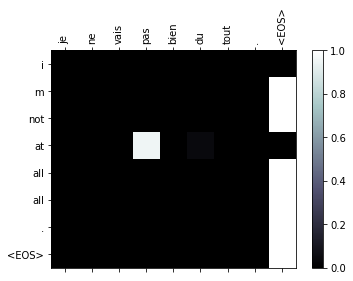

> je suis desole je ne vous ai pas reconnu .
= i m sorry i didn t recognize you .
< i m sorry i didn t recognize you .



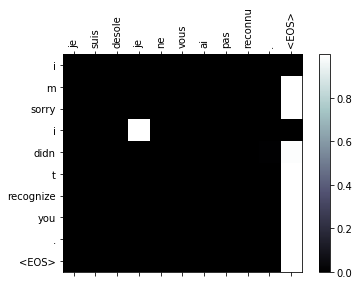

> vous etes chanceuse .
= you re fortunate .
< you re fortunate .



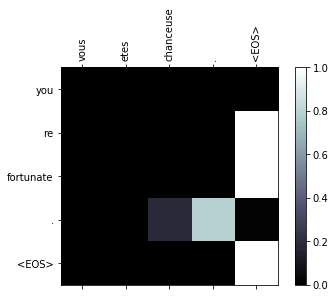

> je suis desole mon pere est sorti .
= i m sorry my father is out .
< i m sorry my father is out .



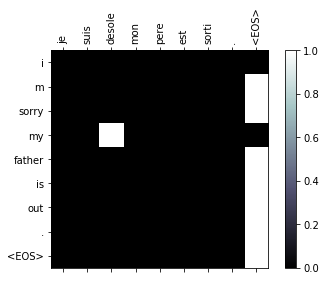

> je ne suis pas actuellement arme .
= i m now unarmed .
< i m not in . .



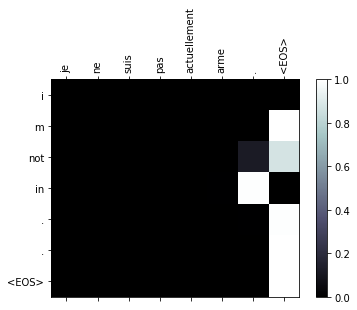

> je suis vegetarienne .
= i m vegetarian .
< i am a vegetarian .



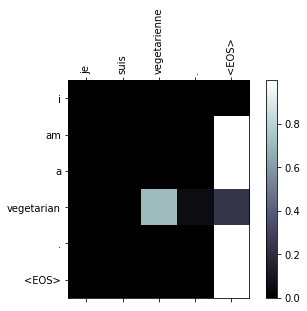

> j en ai fini avec mon travail .
= i am through with my work .
< i m through with my work with job .



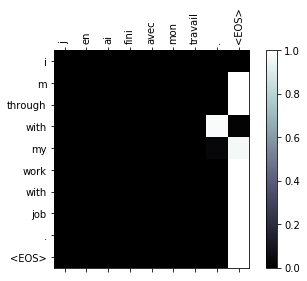

> c est toi la chef .
= you re the leader .
< you re the leader .



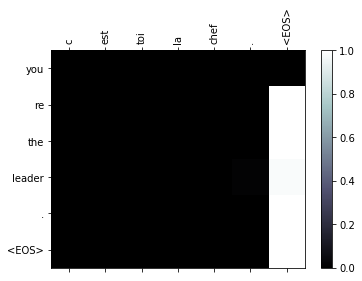

In [86]:
print_results(x, y, encoder, decoder, attention=True)

Exercises
=========
-  Replace the embeddings with pre-trained word embeddings. Here are word embeddings for various languages.

https://fasttext.cc/docs/en/crawl-vectors.html 



# Credits
The original notebook was written by Sean Robertson <https://github.com/spro/practical-pytorch>_